# 语言分类特征工程 

为语言分类模型生成字符卦特征

Dataset: https://downloads.tatoeba.org/exports/

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import os
data_path = os.environ.get('pub_data')

## Dataset

In [3]:
# read in full dataset
data = pd.read_csv(data_path + '/language_classification/sentences.csv', 
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

# Filter by text length
data = data[data['text'].str.len().between(20, 200)]

# Filter by text language
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
data = data[data['lang'].isin(lang)]

# Select 50000 rows for each language
data_trim_list = [data[data['lang'] == l].sample(50000, random_state=100) for l in lang]

# Concatenate all the samples
data_trim = pd.concat(data_trim_list)

# Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1, random_state=100)

train = data_shuffle[:210000]
valid = data_shuffle[210000:270000]
test = data_shuffle[270000:300000]

# Check the shapes to ensure everything is correct
print(f"Train set shape: {train.shape}")
print(f"Validation set shape: {valid.shape}")
print(f"Test set shape: {test.shape}")

Train set shape: (210000, 2)
Validation set shape: (60000, 2)
Test set shape: (30000, 2)


In [38]:
# Save train, valid, test split
train.to_csv(data_path + '/language_classification/train.csv')
valid.to_csv(data_path + '/language_classification/valid.csv')
test.to_csv(data_path + '/language_classification/test.csv')

## Feature engineering 

In [39]:
train = pd.read_csv(data_path + '/language_classification/train.csv', index_col =0)
valid = pd.read_csv(data_path + '/language_classification/valid.csv', index_col =0)
test = pd.read_csv(data_path + '/language_classification/test.csv', index_col =0)
print(len(train),len(valid),len(test))
train.head()

210000 60000 30000


,lang,text
10324955,deu,Das schmeckt nicht besonders gut.
6560456,fra,Penses-tu pouvoir arrêter de faire ça ?
9736718,fra,"Je ne parlerai jamais couramment l'allemand, m..."
9065853,por,Ainda há muito trabalho a ser feito.
4542124,fra,Arkhangelsk est le plus loin des endroits les ...


In [57]:
def get_trigrams(corpus, n_feat=200):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    # fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=n_feat)

    X = vectorizer.fit_transform(corpus)

    # Get model feature names
    feature_names = vectorizer.get_feature_names_out()
    return feature_names

In [58]:
# obtain trigrams from each language
features = {}
features_set = set()

for l in lang:
    
    # get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    # get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    # add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
# create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i

In [59]:
len(features['eng'])

200

In [60]:
# train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

# create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

In [61]:
print(len(train_feat.columns))
train_feat

661


,une,a,ass,ocê,bei,t m,y,n b,ade,y s,...,no,ti,'s,fr,sen,ois,to.,mit,eux,nho
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
209996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
209997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209998,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

# Add target variable 
train_feat['lang'] = list(train['lang'])

train_feat

,une,a,ass,ocê,bei,t m,y,n b,ade,y s,...,ti,'s,fr,sen,ois,to.,mit,eux,nho,lang
0,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,deu
1,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,fra
2,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.333333,0.0,fra
3,0.0,0.166667,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.5,0.0,0.000000,0.0,por
4,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,fra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.000000,0.0,deu
209996,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.333333,0.0,fra
209997,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,fra
209998,0.0,0.000000,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,por


In [63]:
# create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus)

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

# create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])


In [64]:
print(len(valid_feat.columns),len(test_feat.columns))
print(len(train_feat),len(valid_feat),len(test_feat))

662 662
210000 60000 30000


In [48]:
# Save train, valid, test split
train_feat.to_csv(data_path + '/language_classification/train_feat.csv')
valid_feat.to_csv(data_path + '/language_classification/valid_feat.csv')
test_feat.to_csv(data_path + '/language_classification/test_feat.csv')

## Data Exploration

Matrix of shared trigrams:
[200, 56, 52, 47, 42, 49]
[56, 200, 55, 54, 52, 51]
[52, 55, 200, 70, 78, 81]
[47, 54, 70, 200, 97, 99]
[42, 52, 78, 97, 200, 128]
[49, 51, 81, 99, 128, 200]

NaN values in the DataFrame:
0


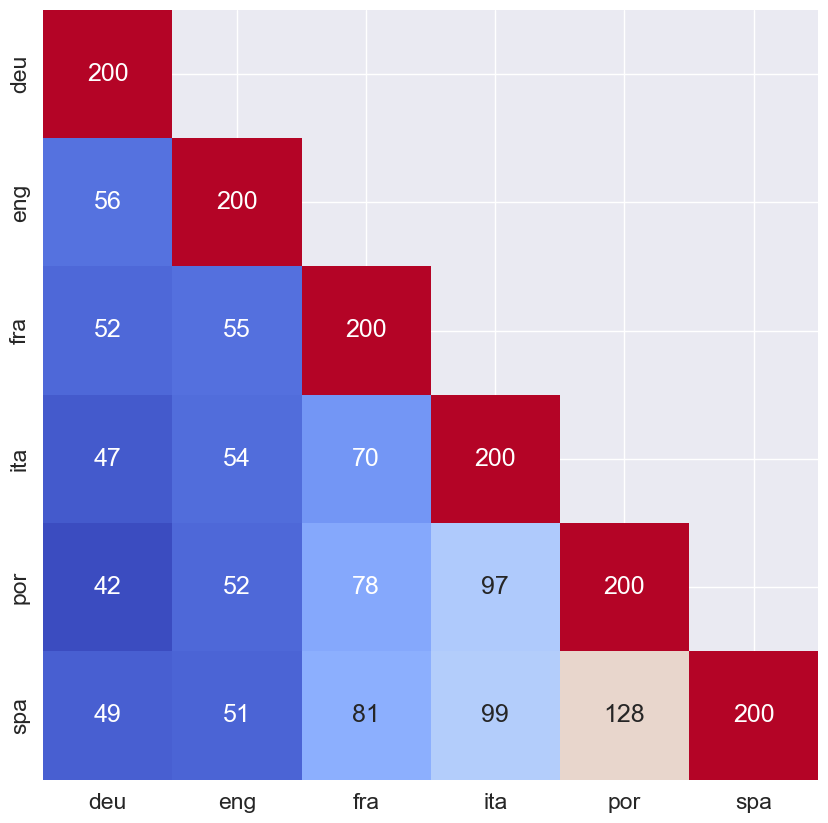

In [65]:
# Calculate number of shared trigrams
labels = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']

mat = []
for i in labels:
    vec = []
    for j in labels:
        l1 = features[i]
        l2 = features[j]
        intersec = [l for l in l1 if l in l2]
        vec.append(len(intersec))
    mat.append(vec)

# Print the matrix to check the values
print("Matrix of shared trigrams:")
for row in mat:
    print(row)

# Convert the matrix to DataFrame
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix_df = pd.DataFrame(mat, columns=lang, index=lang)

# Check for NaN values in the DataFrame
print("\nNaN values in the DataFrame:")
print(conf_matrix_df.isna().sum().sum())  # Check total number of NaNs

# Replace NaN values with 0
conf_matrix_df = conf_matrix_df.fillna(0)

# Create mask for the upper triangle
mask = np.triu(np.ones_like(conf_matrix_df, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df, cmap='coolwarm', annot=True, fmt='d', cbar=False, mask=mask)

plt.savefig('../figures/feat_explore.png', format='png', dpi=150)
plt.show()

## Modelling - Hyper-parameter tunning

In [66]:
train_feat = pd.read_csv(data_path + '/language_classification/train_feat.csv', index_col =0)
valid_feat = pd.read_csv(data_path + '/language_classification/valid_feat.csv', index_col =0)
test_feat = pd.read_csv(data_path + '/language_classification/test_feat.csv', index_col =0)
print(len(train_feat),len(valid_feat),len(test_feat))
train_feat.head()

210000 60000 30000


,une,a,ass,ocê,bei,t m,y,n b,ade,y s,...,ti,'s,fr,sen,ois,to.,mit,eux,nho,lang
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,deu
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,fra
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,fra
3,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.0,por
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,fra


In [67]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# Fit encoder
encoder = LabelEncoder()
encoder.fit(['deu', 'eng', 'fra', 'ita', 'por', 'spa'])

def encode(y):
    """
    Returns a list of one hot encodings 
    
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [68]:
from keras.models import Sequential
from keras.layers import Dense

x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

x_val = valid_feat.drop('lang',axis=1)
y_val = encode(valid_feat['lang'])

In [69]:
def fit_model(nodes,epochs,batch_size):
    model = Sequential()
    model.add(Dense(nodes[0], input_dim=661, activation='relu'))
    model.add(Dense(nodes[1], activation='relu'))
    model.add(Dense(nodes[2], activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(x, y, epochs=epochs, batch_size=batch_size) #fit ANN
    
    train_acc = model.evaluate(x, y)
    val_acc = model.evaluate(x_val, y_val)
    
    return round(train_acc[1]*100,2),round(val_acc[1]*100,2)

In [70]:
nodes = [[100,100,50],[200,200,100],[300,200,100],[500,500,250]]
epochs = [1,2,3,4]
batch_size = [10,100,1000]

results = []
i = 0

for n in nodes:
    print("MODEL: ", i)
    for e in epochs:
        for b in batch_size:
            result = {}
            
            result['model'] = i
            result['nodes'] = n
            result['epochs'] = e
            result['batch_size'] = b
            result['train'], result['valid'] = fit_model(n,e,b)
            
            results.append(result)
            i+= 1

results_final = pd.DataFrame(results)

MODEL:  0


2024-07-05 14:49:45.871881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  12/6563 [..............................] - ETA: 1:04 - loss: 0.0417 - accuracy: 0.9818

2024-07-05 14:53:14.250467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 21s 11ms/step - loss: 0.0508 - accuracy: 0.9816


2024-07-05 14:54:45.166816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/6563 [..............................] - ETA: 27:18 - loss: 0.0793 - accuracy: 0.9375

2024-07-05 14:55:09.535794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/210 [..............................] - ETA: 1:13 - loss: 1.7915 - accuracy: 0.1910

2024-07-05 14:56:36.411267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:15 - loss: 0.0408 - accuracy: 0.9844 

2024-07-05 14:56:40.365294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0547 - accuracy: 0.9806
Epoch 1/2
    1/21000 [..............................] - ETA: 2:07:18 - loss: 1.7834 - accuracy: 0.3000

2024-07-05 14:58:11.021132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 215s 10ms/step - loss: 0.0698 - accuracy: 0.9755
Epoch 2/2
   6/6563 [..............................] - ETA: 1:14 - loss: 0.0226 - accuracy: 0.9948 

2024-07-05 15:05:16.929241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0417 - accuracy: 0.9855
Epoch 1/2


2024-07-05 15:06:41.679179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 24s 11ms/step - loss: 0.0925 - accuracy: 0.9703
Epoch 2/2
  12/6563 [..............................] - ETA: 1:04 - loss: 0.0298 - accuracy: 0.9870

2024-07-05 15:07:29.056435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 9ms/step - loss: 0.0442 - accuracy: 0.9837
Epoch 1/2
  1/210 [..............................] - ETA: 1:07 - loss: 1.7908 - accuracy: 0.2100

2024-07-05 15:08:50.960804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 12ms/step - loss: 0.3226 - accuracy: 0.9259
Epoch 2/2
  12/6563 [..............................] - ETA: 1:02 - loss: 0.0343 - accuracy: 0.9870

2024-07-05 15:08:57.114778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 9ms/step - loss: 0.0437 - accuracy: 0.9843
Epoch 1/3
    1/21000 [..............................] - ETA: 1:47:20 - loss: 1.8032 - accuracy: 0.2000

2024-07-05 15:10:18.910561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 208s 10ms/step - loss: 0.0698 - accuracy: 0.9756
Epoch 2/3
21000/21000 [==============================] - 221s 11ms/step - loss: 0.0393 - accuracy: 0.9857
Epoch 3/3
  11/6563 [..............................] - ETA: 1:12 - loss: 0.0211 - accuracy: 0.9886

2024-07-05 15:21:04.592486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0411 - accuracy: 0.9851
Epoch 1/3
   1/2100 [..............................] - ETA: 9:59 - loss: 1.7928 - accuracy: 0.1700

2024-07-05 15:22:27.483784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 22s 10ms/step - loss: 0.0921 - accuracy: 0.9714
Epoch 2/3
2100/2100 [==============================] - 21s 10ms/step - loss: 0.0416 - accuracy: 0.9847
Epoch 3/3
  12/6563 [..............................] - ETA: 1:03 - loss: 0.0288 - accuracy: 0.9844

2024-07-05 15:23:32.215269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0430 - accuracy: 0.9846
Epoch 1/3
  1/210 [..............................] - ETA: 1:07 - loss: 1.7914 - accuracy: 0.1960

2024-07-05 15:24:54.758101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 12ms/step - loss: 0.3201 - accuracy: 0.9333
Epoch 2/3
210/210 [==============================] - 2s 12ms/step - loss: 0.0442 - accuracy: 0.9840
Epoch 3/3
  11/6563 [..............................] - ETA: 1:12 - loss: 0.0376 - accuracy: 0.9830

2024-07-05 15:25:03.329989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0410 - accuracy: 0.9849
Epoch 1/4
    1/21000 [..............................] - ETA: 13:05:38 - loss: 1.7996 - accuracy: 0.1000

2024-07-05 15:26:32.409763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 207s 10ms/step - loss: 0.0695 - accuracy: 0.9759
Epoch 2/4
21000/21000 [==============================] - 212s 10ms/step - loss: 0.0403 - accuracy: 0.9857
Epoch 3/4
21000/21000 [==============================] - 206s 10ms/step - loss: 0.0293 - accuracy: 0.9896
Epoch 4/4
   6/6563 [..............................] - ETA: 1:11 - loss: 0.0131 - accuracy: 0.9948 

2024-07-05 15:40:22.422302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0462 - accuracy: 0.9856
Epoch 1/4
   1/2100 [..............................] - ETA: 11:07 - loss: 1.7926 - accuracy: 0.2100

2024-07-05 15:41:46.184928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 21s 10ms/step - loss: 0.0931 - accuracy: 0.9709
Epoch 2/4
2100/2100 [==============================] - 21s 10ms/step - loss: 0.0412 - accuracy: 0.9849
Epoch 3/4
2100/2100 [==============================] - 21s 10ms/step - loss: 0.0345 - accuracy: 0.9872
Epoch 4/4
  12/6563 [..............................] - ETA: 1:05 - loss: 0.0142 - accuracy: 0.9974

2024-07-05 15:43:12.057613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0429 - accuracy: 0.9849
Epoch 1/4
  1/210 [..............................] - ETA: 1:03 - loss: 1.7911 - accuracy: 0.1920

2024-07-05 15:44:41.477208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 11ms/step - loss: 0.3227 - accuracy: 0.9302
Epoch 2/4
210/210 [==============================] - 2s 11ms/step - loss: 0.0444 - accuracy: 0.9840
Epoch 3/4
210/210 [==============================] - 2s 12ms/step - loss: 0.0388 - accuracy: 0.9858
Epoch 4/4
  11/6563 [..............................] - ETA: 1:10 - loss: 0.0377 - accuracy: 0.9830

2024-07-05 15:44:52.764909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0424 - accuracy: 0.9841
MODEL:  12


2024-07-05 15:46:18.902372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:12 - loss: 0.0277 - accuracy: 0.9948 

2024-07-05 15:49:56.868946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 20s 11ms/step - loss: 0.0480 - accuracy: 0.9832


2024-07-05 15:51:27.273196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  12/6563 [..............................] - ETA: 1:06 - loss: 0.0576 - accuracy: 0.9844

2024-07-05 15:51:50.581933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0486 - accuracy: 0.9824


2024-07-05 15:53:16.083821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  12/6563 [..............................] - ETA: 1:07 - loss: 0.0459 - accuracy: 0.9766

2024-07-05 15:53:20.175728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0513 - accuracy: 0.9807
Epoch 1/2
    1/21000 [..............................] - ETA: 1:45:47 - loss: 1.7901 - accuracy: 0.3000

2024-07-05 15:54:46.235828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 213s 10ms/step - loss: 0.0702 - accuracy: 0.9754
Epoch 2/2
   7/6563 [..............................] - ETA: 1:02 - loss: 0.0219 - accuracy: 0.9911 

2024-07-05 16:01:58.963306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0524 - accuracy: 0.9830
Epoch 1/2
   1/2100 [..............................] - ETA: 11:32 - loss: 1.7882 - accuracy: 0.2200

2024-07-05 16:03:24.603100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 22s 10ms/step - loss: 0.0818 - accuracy: 0.9734
Epoch 2/2
   1/6563 [..............................] - ETA: 24:15 - loss: 0.0420 - accuracy: 1.0000

2024-07-05 16:04:11.636438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0409 - accuracy: 0.9848
Epoch 1/2
  1/210 [..............................] - ETA: 1:18 - loss: 1.7921 - accuracy: 0.1730

2024-07-05 16:05:36.940403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 12ms/step - loss: 0.2323 - accuracy: 0.9482
Epoch 2/2
   6/6563 [..............................] - ETA: 1:13 - loss: 0.0392 - accuracy: 0.9844 

2024-07-05 16:05:43.416816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0432 - accuracy: 0.9841
Epoch 1/3
    1/21000 [..............................] - ETA: 1:52:14 - loss: 1.7855 - accuracy: 0.3000

2024-07-05 16:07:06.638840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 211s 10ms/step - loss: 0.0698 - accuracy: 0.9756
Epoch 2/3
21000/21000 [==============================] - 214s 10ms/step - loss: 0.0380 - accuracy: 0.9870
Epoch 3/3
   6/6563 [..............................] - ETA: 1:11 - loss: 0.0228 - accuracy: 0.9896 

2024-07-05 16:17:51.617741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0436 - accuracy: 0.9862
Epoch 1/3
   1/2100 [..............................] - ETA: 12:14 - loss: 1.7954 - accuracy: 0.1700

2024-07-05 16:19:15.361967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 22s 10ms/step - loss: 0.0828 - accuracy: 0.9728
Epoch 2/3
2100/2100 [==============================] - 22s 11ms/step - loss: 0.0397 - accuracy: 0.9853
Epoch 3/3
  11/6563 [..............................] - ETA: 1:11 - loss: 0.0300 - accuracy: 0.9915

2024-07-05 16:20:23.687936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0510 - accuracy: 0.9823
Epoch 1/3
  1/210 [..............................] - ETA: 1:09 - loss: 1.7928 - accuracy: 0.1490

2024-07-05 16:21:50.678513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 12ms/step - loss: 0.2331 - accuracy: 0.9485
Epoch 2/3
210/210 [==============================] - 3s 14ms/step - loss: 0.0416 - accuracy: 0.9846
Epoch 3/3
  11/6563 [..............................] - ETA: 1:08 - loss: 0.0287 - accuracy: 0.9830

2024-07-05 16:22:00.622433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0418 - accuracy: 0.9844
Epoch 1/4
    1/21000 [..............................] - ETA: 2:06:02 - loss: 1.7806 - accuracy: 0.2000

2024-07-05 16:23:25.028492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 215s 10ms/step - loss: 0.0699 - accuracy: 0.9760
Epoch 2/4
21000/21000 [==============================] - 220s 10ms/step - loss: 0.0379 - accuracy: 0.9868
Epoch 3/4
21000/21000 [==============================] - 223s 11ms/step - loss: 0.0259 - accuracy: 0.9912
Epoch 4/4
  11/6563 [..............................] - ETA: 1:10 - loss: 0.0078 - accuracy: 0.9972

2024-07-05 16:38:06.276201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0572 - accuracy: 0.9858
Epoch 1/4
   1/2100 [..............................] - ETA: 12:57 - loss: 1.7884 - accuracy: 0.2200

2024-07-05 16:39:32.173593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 22s 10ms/step - loss: 0.0815 - accuracy: 0.9725
Epoch 2/4
2100/2100 [==============================] - 22s 10ms/step - loss: 0.0396 - accuracy: 0.9856
Epoch 3/4
2100/2100 [==============================] - 22s 10ms/step - loss: 0.0293 - accuracy: 0.9892
Epoch 4/4
   6/6563 [..............................] - ETA: 1:15 - loss: 0.0177 - accuracy: 0.9948 

2024-07-05 16:41:00.813411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0421 - accuracy: 0.9860
Epoch 1/4
  1/210 [..............................] - ETA: 1:13 - loss: 1.7925 - accuracy: 0.1660

2024-07-05 16:42:25.458708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 13ms/step - loss: 0.2339 - accuracy: 0.9503
Epoch 2/4
210/210 [==============================] - 3s 12ms/step - loss: 0.0420 - accuracy: 0.9845
Epoch 3/4
210/210 [==============================] - 3s 12ms/step - loss: 0.0371 - accuracy: 0.9862
Epoch 4/4
  11/6563 [..............................] - ETA: 1:09 - loss: 0.0321 - accuracy: 0.9830

2024-07-05 16:42:37.484291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0405 - accuracy: 0.9847
MODEL:  24


2024-07-05 16:44:02.600214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:16 - loss: 0.0477 - accuracy: 0.9844 

2024-07-05 16:47:46.781629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/2100 [..............................] - ETA: 13:12 - loss: 1.7911 - accuracy: 0.1800

2024-07-05 16:49:12.534893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:16 - loss: 0.0477 - accuracy: 0.9740 

2024-07-05 16:49:36.256443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0472 - accuracy: 0.9831


2024-07-05 16:51:00.722971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:32 - loss: 0.0346 - accuracy: 0.9896 

2024-07-05 16:51:05.151269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0497 - accuracy: 0.9819
Epoch 1/2


2024-07-05 16:52:33.085414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 231s 11ms/step - loss: 0.0705 - accuracy: 0.9753
Epoch 2/2
   5/6563 [..............................] - ETA: 1:26 - loss: 0.0346 - accuracy: 0.9875 

2024-07-05 17:00:06.141085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0471 - accuracy: 0.9833
Epoch 1/2


2024-07-05 17:01:35.099998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 23s 11ms/step - loss: 0.0796 - accuracy: 0.9743
Epoch 2/2
   5/6563 [..............................] - ETA: 1:37 - loss: 0.0266 - accuracy: 0.9875 

2024-07-05 17:02:21.987482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0402 - accuracy: 0.9852
Epoch 1/2
  1/210 [..............................] - ETA: 1:08 - loss: 1.7944 - accuracy: 0.1490

2024-07-05 17:03:48.897427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 12ms/step - loss: 0.2132 - accuracy: 0.9535
Epoch 2/2
   6/6563 [..............................] - ETA: 1:18 - loss: 0.0303 - accuracy: 0.9844 

2024-07-05 17:03:55.252108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0413 - accuracy: 0.9848
Epoch 1/3
    1/21000 [..............................] - ETA: 2:03:01 - loss: 1.7912 - accuracy: 0.3000

2024-07-05 17:05:19.774035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 214s 10ms/step - loss: 0.0693 - accuracy: 0.9758
Epoch 2/3
21000/21000 [==============================] - 220s 10ms/step - loss: 0.0368 - accuracy: 0.9875
Epoch 3/3
   5/6563 [..............................] - ETA: 1:24 - loss: 0.0054 - accuracy: 1.0000 

2024-07-05 17:16:15.590542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0483 - accuracy: 0.9866
Epoch 1/3
   1/2100 [..............................] - ETA: 11:10 - loss: 1.7950 - accuracy: 0.1500

2024-07-05 17:17:40.950732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 23s 11ms/step - loss: 0.0800 - accuracy: 0.9741
Epoch 2/3
2100/2100 [==============================] - 23s 11ms/step - loss: 0.0382 - accuracy: 0.9859
Epoch 3/3
   6/6563 [..............................] - ETA: 1:14 - loss: 0.0180 - accuracy: 0.9896 

2024-07-05 17:18:50.139669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0384 - accuracy: 0.9866
Epoch 1/3
  1/210 [..............................] - ETA: 1:20 - loss: 1.7937 - accuracy: 0.1390

2024-07-05 17:20:16.060789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 13ms/step - loss: 0.2117 - accuracy: 0.9543
Epoch 2/3
210/210 [==============================] - 3s 13ms/step - loss: 0.0416 - accuracy: 0.9847
Epoch 3/3
  11/6563 [..............................] - ETA: 1:13 - loss: 0.0294 - accuracy: 0.9858

2024-07-05 17:20:25.164949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0408 - accuracy: 0.9844
Epoch 1/4
    1/21000 [..............................] - ETA: 1:49:25 - loss: 1.7857 - accuracy: 0.3000

2024-07-05 17:21:49.670880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 220s 10ms/step - loss: 0.0696 - accuracy: 0.9757
Epoch 2/4
21000/21000 [==============================] - 225s 11ms/step - loss: 0.0377 - accuracy: 0.9874
Epoch 3/4
21000/21000 [==============================] - 225s 11ms/step - loss: 0.0233 - accuracy: 0.9923
Epoch 4/4
   6/6563 [..............................] - ETA: 1:21 - loss: 0.0034 - accuracy: 1.0000 

2024-07-05 17:36:46.916625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0536 - accuracy: 0.9865
Epoch 1/4
   1/2100 [..............................] - ETA: 12:12 - loss: 1.7979 - accuracy: 0.0800

2024-07-05 17:38:12.983075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 23s 11ms/step - loss: 0.0797 - accuracy: 0.9747
Epoch 2/4
2100/2100 [==============================] - 22s 11ms/step - loss: 0.0380 - accuracy: 0.9860
Epoch 3/4
2100/2100 [==============================] - 22s 11ms/step - loss: 0.0250 - accuracy: 0.9908
Epoch 4/4
   5/6563 [..............................] - ETA: 1:22 - loss: 0.0056 - accuracy: 1.0000 

2024-07-05 17:39:43.513970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0414 - accuracy: 0.9863
Epoch 1/4
  1/210 [..............................] - ETA: 1:10 - loss: 1.7924 - accuracy: 0.1800

2024-07-05 17:41:08.300227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 12ms/step - loss: 0.2130 - accuracy: 0.9498
Epoch 2/4
210/210 [==============================] - 3s 12ms/step - loss: 0.0408 - accuracy: 0.9851
Epoch 3/4
210/210 [==============================] - 3s 13ms/step - loss: 0.0363 - accuracy: 0.9863
Epoch 4/4
   6/6563 [..............................] - ETA: 1:21 - loss: 0.0265 - accuracy: 0.9896 

2024-07-05 17:41:19.936642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0396 - accuracy: 0.9855
MODEL:  36


2024-07-05 17:42:44.901863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:13 - loss: 0.0326 - accuracy: 0.9844 

2024-07-05 17:46:30.528495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0543 - accuracy: 0.9810


2024-07-05 17:47:57.089485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:17 - loss: 0.0369 - accuracy: 0.9896 

2024-07-05 17:48:21.423396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0498 - accuracy: 0.9817


2024-07-05 17:49:47.477890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   6/6563 [..............................] - ETA: 1:18 - loss: 0.0533 - accuracy: 0.9792 

2024-07-05 17:49:52.031166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0467 - accuracy: 0.9825
Epoch 1/2
    1/21000 [..............................] - ETA: 1:49:37 - loss: 1.7908 - accuracy: 0.1000

2024-07-05 17:51:19.554023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 226s 11ms/step - loss: 0.0724 - accuracy: 0.9753
Epoch 2/2
   6/6563 [..............................] - ETA: 1:12 - loss: 0.0127 - accuracy: 0.9948 

2024-07-05 17:58:55.983445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0529 - accuracy: 0.9846
Epoch 1/2
   1/2100 [..............................] - ETA: 12:09 - loss: 1.7878 - accuracy: 0.1600

2024-07-05 18:00:23.616286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 23s 11ms/step - loss: 0.0737 - accuracy: 0.9749
Epoch 2/2
   6/6563 [..............................] - ETA: 1:15 - loss: 0.0149 - accuracy: 0.9948 

2024-07-05 18:01:10.797756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0438 - accuracy: 0.9844
Epoch 1/2
  1/210 [..............................] - ETA: 1:18 - loss: 1.7906 - accuracy: 0.1960

2024-07-05 18:02:38.401029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 15ms/step - loss: 0.1539 - accuracy: 0.9620
Epoch 2/2
   6/6563 [..............................] - ETA: 1:21 - loss: 0.0318 - accuracy: 0.9896 

2024-07-05 18:02:45.689948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0409 - accuracy: 0.9850
Epoch 1/3
    1/21000 [..............................] - ETA: 1:49:21 - loss: 1.7945 - accuracy: 0.2000

2024-07-05 18:04:11.346628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 229s 11ms/step - loss: 0.0725 - accuracy: 0.9751
Epoch 2/3
21000/21000 [==============================] - 230s 11ms/step - loss: 0.0378 - accuracy: 0.9877
Epoch 3/3
   4/6563 [..............................] - ETA: 1:54 - loss: 0.0101 - accuracy: 1.0000 

2024-07-05 18:15:42.794619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0486 - accuracy: 0.9868
Epoch 1/3
   1/2100 [..............................] - ETA: 11:24 - loss: 1.7897 - accuracy: 0.1500

2024-07-05 18:17:10.246081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 23s 11ms/step - loss: 0.0734 - accuracy: 0.9753
Epoch 2/3
2100/2100 [==============================] - 23s 11ms/step - loss: 0.0347 - accuracy: 0.9874
Epoch 3/3
   6/6563 [..............................] - ETA: 1:17 - loss: 0.0041 - accuracy: 1.0000 

2024-07-05 18:18:20.338266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0434 - accuracy: 0.9861
Epoch 1/3
  1/210 [..............................] - ETA: 1:17 - loss: 1.7906 - accuracy: 0.1920

2024-07-05 18:19:46.702710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 15ms/step - loss: 0.1545 - accuracy: 0.9578
Epoch 2/3
210/210 [==============================] - 3s 14ms/step - loss: 0.0385 - accuracy: 0.9857
Epoch 3/3
   6/6563 [..............................] - ETA: 1:21 - loss: 0.0209 - accuracy: 0.9948 

2024-07-05 18:19:57.037901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0397 - accuracy: 0.9854
Epoch 1/4
    1/21000 [..............................] - ETA: 1:59:13 - loss: 1.7849 - accuracy: 0.2000

2024-07-05 18:21:24.012597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21000/21000 [==============================] - 226s 11ms/step - loss: 0.0722 - accuracy: 0.9754
Epoch 2/4
21000/21000 [==============================] - 230s 11ms/step - loss: 0.0374 - accuracy: 0.9876
Epoch 3/4
21000/21000 [==============================] - 234s 11ms/step - loss: 0.0230 - accuracy: 0.9928
Epoch 4/4
21000/21000 [==============================] - 237s 11ms/step - loss: 0.0145 - accuracy: 0.9959


2024-07-05 18:36:52.848349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0598 - accuracy: 0.9870
Epoch 1/4
   1/2100 [..............................] - ETA: 11:59 - loss: 1.7914 - accuracy: 0.1800

2024-07-05 18:38:21.303955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 23s 11ms/step - loss: 0.0733 - accuracy: 0.9747
Epoch 2/4
2100/2100 [==============================] - 22s 11ms/step - loss: 0.0346 - accuracy: 0.9874
Epoch 3/4
2100/2100 [==============================] - 23s 11ms/step - loss: 0.0204 - accuracy: 0.9927
Epoch 4/4
   4/6563 [..............................] - ETA: 2:00 - loss: 0.0112 - accuracy: 0.9922 

2024-07-05 18:39:52.195676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0495 - accuracy: 0.9855
Epoch 1/4
  1/210 [..............................] - ETA: 1:05 - loss: 1.7916 - accuracy: 0.1860

2024-07-05 18:41:18.756403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 14ms/step - loss: 0.1536 - accuracy: 0.9653
Epoch 2/4
210/210 [==============================] - 3s 14ms/step - loss: 0.0384 - accuracy: 0.9857
Epoch 3/4
210/210 [==============================] - 3s 13ms/step - loss: 0.0307 - accuracy: 0.9887
Epoch 4/4
  11/6563 [..............................] - ETA: 1:12 - loss: 0.0163 - accuracy: 0.9972

2024-07-05 18:41:31.214450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 20s 10ms/step - loss: 0.0404 - accuracy: 0.9857


In [71]:
results_final[results_final.valid == results_final.valid.max()]

,model,nodes,epochs,batch_size,train,valid
45,45,"[500, 500, 250]",4,10,99.82,98.7


In [72]:
results_final[results_final.valid>98.3]

,model,nodes,epochs,batch_size,train,valid
1,1,"[100, 100, 50]",1,100,98.64,98.33
3,3,"[100, 100, 50]",2,10,99.16,98.55
4,4,"[100, 100, 50]",2,100,98.82,98.37
5,5,"[100, 100, 50]",2,1000,98.64,98.43
6,6,"[100, 100, 50]",3,10,99.40,98.51
7,7,"[100, 100, 50]",3,100,99.07,98.46
8,8,"[100, 100, 50]",3,1000,98.81,98.49
9,9,"[100, 100, 50]",4,10,99.54,98.56
10,10,"[100, 100, 50]",4,100,99.23,98.49
11,11,"[100, 100, 50]",4,1000,98.82,98.41


##  Modelling - Final Model

In [73]:
from keras.models import Sequential
from keras.layers import Dense

#Get training data
x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

#Define model
model = Sequential()
model.add(Dense(500, input_dim=661, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x, y, epochs=4, batch_size=100)

Epoch 1/4
   1/2100 [..............................] - ETA: 12:23 - loss: 1.7922 - accuracy: 0.1800

2024-07-05 18:43:00.610924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2100/2100 [==============================] - 23s 11ms/step - loss: 0.0737 - accuracy: 0.9753
Epoch 2/4
2100/2100 [==============================] - 23s 11ms/step - loss: 0.0349 - accuracy: 0.9875
Epoch 3/4
2100/2100 [==============================] - 23s 11ms/step - loss: 0.0204 - accuracy: 0.9926
Epoch 4/4
2100/2100 [==============================] - 23s 11ms/step - loss: 0.0124 - accuracy: 0.9957


938/938 [==============================] - 2s 2ms/step
Accuracy: 0.9860333333333333


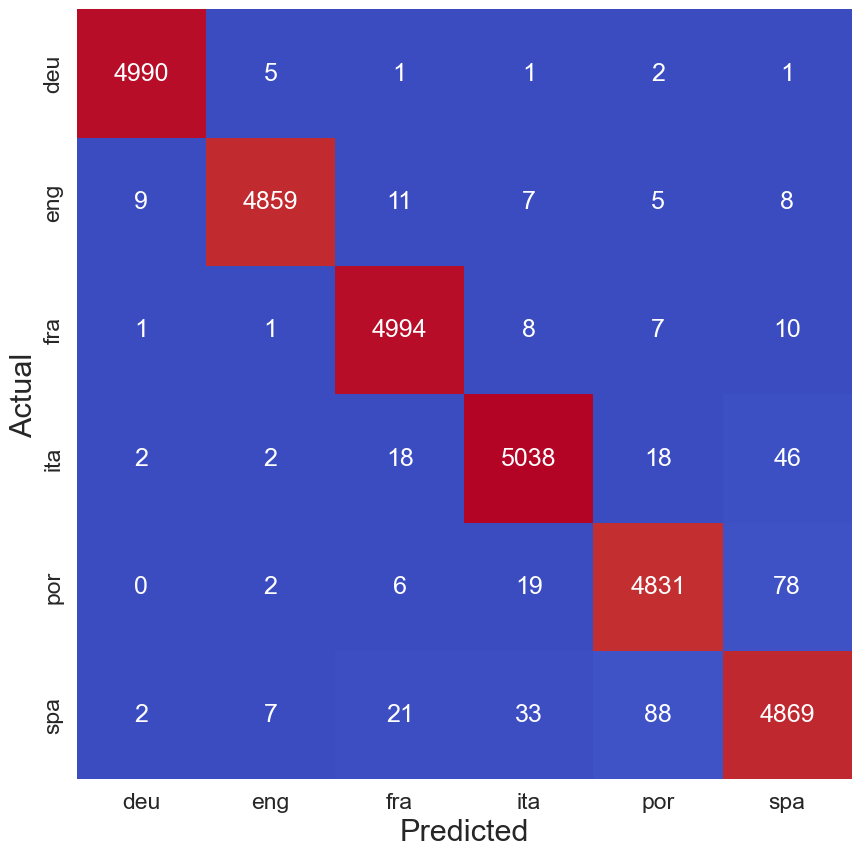

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# x_test 和 y_test 已经定义，并且 model 是一个已训练好的 Keras 模型
x_test = test_feat.drop('lang', axis=1)
y_test = test_feat['lang']

# Use model.predict to get probabilities
predictions_prob = model.predict(x_test)
# Find the index of the highest probability for each sample
labels = np.argmax(predictions_prob, axis=1)
predictions = encoder.inverse_transform(labels)

# Ensure y_test is a 1D array
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# Accuracy on test set
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Create confusion matrix
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=lang, index=lang)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df, cmap='coolwarm', annot=True, fmt='.5g', cbar=False)
plt.xlabel('Predicted', fontsize=22)
plt.ylabel('Actual', fontsize=22)

plt.savefig('../figures/model_eval.png', format='png', dpi=150)
plt.show()